**Fraud Analytics Assignment**  
**Title: Trust Rank**  
---
**Group members:**  
**Name&emsp;: Dindorkar Mayuresh Rajesh**  
**Roll No&nbsp;: CS23MTECH14007**  

**Name&emsp;: Sanyam Kaul**  
**Roll No&nbsp;: CS23MTECH14011**  

**Name&emsp;: Shrenik Ganguli**  
**Roll No&nbsp;: CS23MTECH14014**  

**Name&emsp;: Morey Piyush Prabhakar**  
**Roll No&nbsp;: AI23MTECH14003**  

---

**Importing libraries:**

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import operator
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

---
**Utility Functions:**

In [2]:
def plot_scatter_plot(x, y, bad_x, bad_y):
    plt.scatter(x = x, y = y, label="Trust-Rank of nodes", color='green')
    plt.axhline(y=0.007, color='red', linestyle='--', label='Threshold Trust Score')
    plt.scatter(x = bad_x, y = bad_y,  marker="d", color="orange", label="Bad nodes already known")
    plt.ylabel("Trust-Rank Score (Bad trust score)")
    plt.xlabel("Node ID [Re-numbered between 0-800]")
    plt.legend()
    plt.show()

In [3]:
def plot_histogram(df):
    trust_ranks = df['Trust-Score']
    bin_values = sorted({round(val, 3) for val in trust_ranks})
    plt.figure(figsize=(8, 8))
    sns.histplot(data=df, y='Trust-Score', bins = bin_values, color="orange")
    plt.title("Trust Scores Vs Frequency of Nodes")
    plt.xlabel("Node count (Frequency)")
    plt.ylabel("Trust Score (Bad trust score)")
    plt.show()

**Loading Payments.csv and bad_sender.csv files:**

In [4]:
payments_df = pd.read_csv('Payments.csv')
payments_df.head()

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396


In [5]:
bad_sender_df = pd.read_csv('bad_sender.csv')
bad_sender_df.head()

,Bad Sender
0,1303
1,1259
2,1562
3,1147
4,1393


--- 

**Extracting all unique nodes and bad nodes from dataset:**

In [6]:
all_bad_nodes = bad_sender_df["Bad Sender"].unique().tolist()
all_unique_nodes = sorted(list(set(payments_df["Sender"]) | set(payments_df["Receiver"]))) # It includes bad nodes also

**Storing the Node ID mappings in dictionaries:**

In [7]:
# nodes_dict: Stores original Node ID to new Node ID mapping: {1001: 0, 1002: 1,....}
nodes_dict = {node: index for index, node in enumerate(all_unique_nodes)}

# node_index_to_label: Stores new Node ID to original Node ID mapping: {0: 1001, 1 : 1002,....}
node_index_to_label = {}
for key, value in nodes_dict.items():
    node_index_to_label[value] = key

# Extracting node indices from the nodes_dict
all_nodes = [nodes_dict[i] for i in all_unique_nodes if i in nodes_dict]
bad_nodes = [nodes_dict[i] for i in all_bad_nodes if i in nodes_dict]

total_nodes_count = len(all_nodes)
bad_nodes_count =  len(bad_nodes)
print(f'Count of all nodes: {total_nodes_count}')
print(f'Count of bad nodes: {bad_nodes_count}')

Count of all nodes: 799
Count of bad nodes: 20


**TrustRank implementation:**
- Connected nodes having no outlinks back to bad nodes to avoid trust leakage.

In [8]:
'''
Creating the adjacency matrix by considering:
'Sender' as source node, 'Receiver' as destination node, and 'Amount' as edge weight
 adj_list_dict: {
                     0: {188: 88788, 344: 22566},
                     1: {358: 20660, 532: 6760},
                     2: {106: 21277, 332: 54988, 510: 43476, 452: 62765, 666: 48368},
                     3: {168: 113338, 193: 99620, 712: 120571},
                     4: {252: 60191},
                     ...
                 }
'''
adj_list_dict = {}
for i in all_nodes:
    adj_list_dict[i] = {}
for index, row in payments_df.iterrows():
    from_node = nodes_dict[row.Sender]
    to_node = nodes_dict[row.Receiver]
    amount = row.Amount
    adj_list = adj_list_dict[from_node]
    adj_list[to_node] = amount

---  
**Constructing Transition Matrix:**

In [9]:
T = np.zeros((total_nodes_count, total_nodes_count))
for from_node in adj_list_dict:
    adj_list = adj_list_dict[from_node]
    sum_of_amount = sum(adj_list.values())
    for to_node in adj_list:
        T[to_node][from_node] = T[to_node][from_node] + (adj_list[to_node]/sum_of_amount)

---  
**Constructing Initial TrustRank Vector:**  
- d: Denotes the static score distribution vector
- Initially, we assign trust score of '1 / (Number_of_bad_nodes)' to all bad nodes and 0 to all good nodes

In [10]:
d = np.full(total_nodes_count, 0.0)
for node in bad_nodes:
    d[node] = (1./bad_nodes_count)
d = d.reshape(-1, 1)

**Sum of entries of static scores distribution vector should be equal to 1:**

In [11]:
print('Sum of all elements of r:', sum(d))

Sum of all elements of r: [1.]


--- 

**Executing the Trust-Rank algorithm:**  
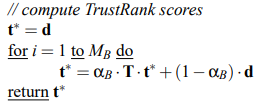

In [12]:
t = d
damping_factor = 0.85
t = damping_factor * T.dot(t) + (1 - damping_factor) * d
iteration = 1
total_iterations = 100

while iteration <= total_iterations:
    t = damping_factor * T.dot(t) + (1 - damping_factor) * d
    iteration += 1
    if iteration % 10 == 0:
        print("Iteration:", iteration)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100


In [13]:
trust_rank_node_score = [] # to store the node and the corresponding trustrank score
for k in range(0, len(t)):
        trust_rank_node_score.append([k, t[k]])
        
# sort the trustrank scores in the decreasing order
trust_rank_node_score = sorted(trust_rank_node_score, key = operator.itemgetter(1), reverse = True)

In [14]:
columns = ['Node', 'Trust-Score']
df = pd.DataFrame(columns=columns)

for [node_index, score] in trust_rank_node_score:
    new_row = {'Node': node_index, 'Trust-Score': score[0]}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

**Printing few computed Trust rank values:**

In [15]:
df.head(n = 25)

,Node,Trust-Score
0,203,0.021315
1,41,0.018441
2,198,0.017904
3,85,0.015963
4,6,0.014853
5,529,0.013112
6,33,0.012231
7,75,0.011430
8,93,0.011229
9,97,0.010573


In [16]:
columns = ['Node', 'Trust-Score']
bad_node_score_df = pd.DataFrame(columns=columns)

for node in bad_nodes:
    if node in df['Node']:
        index = df['Node'].index[df['Node'] == node][0]
        new_row = {'Node': node, 'Trust-Score': df['Trust-Score'][index]}
        bad_node_score_df = pd.concat([bad_node_score_df, pd.DataFrame([new_row])], ignore_index=True)

---  
**Scatter-Plot showing Node ID vs Trust Score of respective nodes:**  
 - Here, high Trust score shows that the node is bad

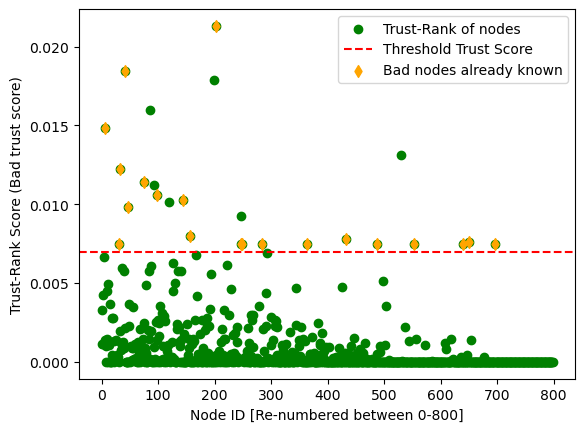

In [17]:
plot_scatter_plot(x = df['Node'], y = df['Trust-Score'], bad_x = bad_node_score_df['Node'], bad_y = bad_node_score_df['Trust-Score'])

**Plotting Trust Scores of all nodes in Descending Order:**

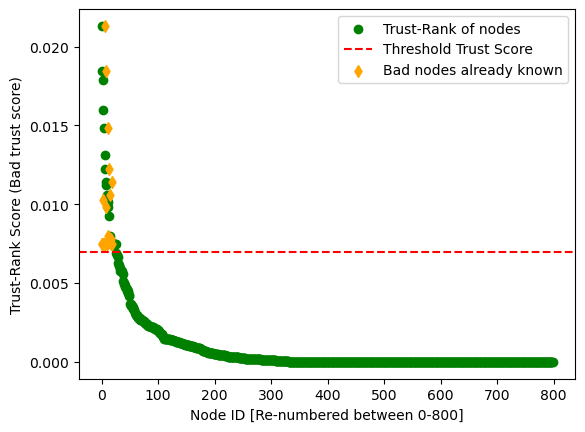

In [18]:
plot_scatter_plot(x = np.arange(total_nodes_count), y = df['Trust-Score'], bad_x = np.arange(bad_nodes_count), bad_y = bad_node_score_df['Trust-Score'])

**Plotting histogram of Trust Score Vs Frequency of Nodes:**  
- From the plot below we can observe that most of the nodes are good with trust scores ranging from 0.000 to 0.003 (Approx)

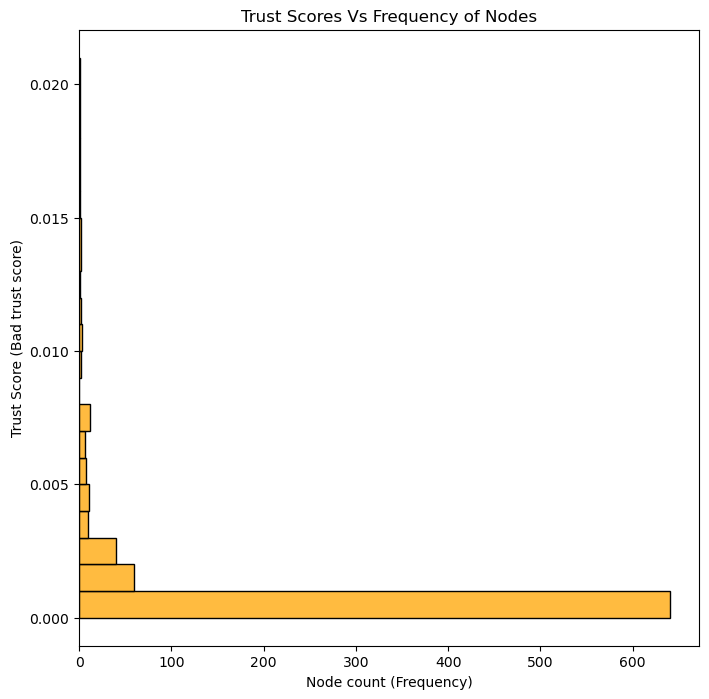

In [19]:
plot_histogram(df)

---
**Results & Observations:**  

- We can observe that, all the bad nodes have the trust score (bad trust score) above the threshold (0.007).
- Bad nodes are highlited by diamond symbol in above plots.
- Hence, all the good nodes (non-diamond nodes) that lie above the threshold are the **possible bad nodes**.